<a href="https://colab.research.google.com/github/Zero00502/Sonar-detection/blob/main/Object_Detection_Framework_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#import kagglehub
#sierra022_sonar_imaging_mine_detection_path = kagglehub.dataset_download('sierra022/sonar-imaging-mine-detection')

#print('Data source import complete.')


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sierra022/sonar-imaging-mine-detection")

print("Path to dataset files:", path)

100%|██████████| 208M/208M [00:02<00:00, 79.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8


In [3]:
import os
import shutil

# Set the base path based on your folder structure
base_path = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8'

# Define paths for the main train directory
train_images_path = os.path.join(base_path, 'train/train/images')
train_labels_path = os.path.join(base_path, 'train/train/labels')

# Ensure the train directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)

# Define dataset folders to consolidate into train
folders_to_merge = ['validation', 'test']

# Loop through the folders to merge data into the train folder
for folder in folders_to_merge:
    dataset_path = os.path.join(base_path, folder)

    # Paths for images and labels in the current folder
    images_path = os.path.join(dataset_path, 'images')
    labels_path = os.path.join(dataset_path, 'labels')

    # Move images to the train folder
    if os.path.exists(images_path):
        for image_file in os.listdir(images_path):
            src_image = os.path.join(images_path, image_file)
            dest_image = os.path.join(train_images_path, image_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_image):
                print(f"Warning: {dest_image} already exists. Skipping.")
            else:
                shutil.move(src_image, dest_image)

    # Move labels to the train folder
    if os.path.exists(labels_path):
        for label_file in os.listdir(labels_path):
            src_label = os.path.join(labels_path, label_file)
            dest_label = os.path.join(train_labels_path, label_file)
            # Avoid overwriting files with the same name
            if os.path.exists(dest_label):
                print(f"Warning: {dest_label} already exists. Skipping.")
            else:
                shutil.move(src_label, dest_label)

    # Remove the folder after merging
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path, ignore_errors=True)
        print(f"Removed folder: {dataset_path}")

# Save the final train path in a variable
final_train_path = os.path.join(base_path, 'train/train')
print(f"Final train folder path: {final_train_path}")


Removed folder: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/test
Final train folder path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train


In [ ]:
import os

def list_folder_structure(base_path, level=0):
    # List all items in the current directory
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        print("  " * level + f"- {item}/")
        # If the item is a directory, recursively list its contents
        if os.path.isdir(item_path):
            list_folder_structure(item_path, level + 1)

# Specify the path to your root directory
base_path = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8'
list_folder_structure(base_path)


# This code provides a solid foundation for training an object detection model using the provided image and annotation data. You can now proceed to build and train the actual model, using the prepared data and appropriate neural network architectures.

> The code imports necessary libraries for image processing, neural networks, data manipulation, and model evaluation.

    It defines paths to the image and annotation directories.
    
    The load_annotations function reads and parses annotation files.
    
    The data preparation steps involve loading images and annotations, padding annotations to ensure consistent shapes, converting data to NumPy arrays, and splitting data into training and testing sets.
    
    The custom data generator class is used to efficiently batch the data during training.
    
    Data generators are created for training and testing sets.



> Import Necessary Libraries:

    os: Provides functions for interacting with the operating system, such as file and directory operations.
    
    cv2: Open-source computer vision library for image processing and analysis.
    
    numpy: Numerical Python library for working with arrays and matrices.
    
    tensorflow.keras.models: Contains classes for creating and training neural network models.
    
    tensorflow.keras.layers: Provides various layers for building neural networks, such as convolutional, pooling, and fully connected layers.
    
    tensorflow.keras.preprocessing.image: Offers functions for preprocessing image data, including data augmentation.
    
    tensorflow.keras.utils: Contains utility functions for working with Keras models and data.
    
    sklearn.model_selection: Provides tools for splitting data into training and testing sets.
    
> Define Paths:

    image_dir

    : Specifies the directory containing the image files.
    annotation_dir: Specifies the directory containing the corresponding annotation files.

> Load Annotations Function:

    load_annotations(annotation_file):
        Reads the lines from the specified annotation file.
        Parses each line to extract the class ID, bounding box center coordinates, and dimensions.
        Appends the extracted annotation information to a list.
        Returns the list of annotations.

In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split


# Define the paths to your data
image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
annotation_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'


def load_annotations(annotation_file):
  """Loads annotations from a text file."""
  with open(annotation_file, 'r') as f:
    lines = f.readlines()
  annotations = []
  for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])
    annotations.append([class_id, x_center, y_center, width, height])
  return annotations

> Prepare Data:

    imagesand labels lists are initialized to store the image data and corresponding annotations.
    max_annotations variable keeps track of the maximum number of annotations per image.
    Iterate over the image files in the image_dir directory:

    Read the image and resize it to (224, 224) for consistency.
    Load the corresponding annotations from the annotation file.
    Update max_annotations if the current image has more annotations.
    Append the image and annotations to the respective lists.

In [5]:
# Prepare data
images = []
labels = []
max_annotations = 0  # Keep track of the maximum number of annotations per image

for filename in os.listdir(image_dir):
  if filename.endswith('.jpg'):
    image_path = os.path.join(image_dir, filename)
    annotation_file = os.path.join(annotation_dir, filename[:-4] + '.txt')

    if os.path.exists(annotation_file):
      img = cv2.imread(image_path)
      img = cv2.resize(img, (224, 224))  # Resize images to a consistent size
      images.append(img)
      annotations = load_annotations(annotation_file)

      # Update max_annotations if current image has more annotations
      max_annotations = max(max_annotations, len(annotations))
      labels.append(annotations)


> Pad Annotations:

    Create a new

    padded_labels list to store the padded annotations.
    Iterate over each annotation list:
        Pad the list with [0, 0, 0, 0, 0] elements until it reaches the max_annotations length.
        Append the padded annotation list to padded_labels.

> Convert to NumPy Arrays:

    Convert the images and padded_labels lists to NumPy arrays for efficient processing.

> Split Data:

    Split the data into training and testing sets using train_test_split.

> Reshape Labels:

    Reshape the labels to (num_samples, max_annotations, 5) to match the expected input shape for the model.

> Custom Data Generator:

    DataGenerator class:
        Initializes with the training or testing data and batch size.
        Implements the __len__ method to return the number of batches.
        Implements the __getitem__ method to yield batches of images and labels.

> Create Data Generators:

    Create instances of the DataGenerator class for training and testing data.

In [6]:
# Pad annotations to ensure consistent shape
# Create a new list to store padded labels
padded_labels = []
for annotation_list in labels:
    # Pad with [0, 0, 0, 0, 0] to reach max_annotations length
    while len(annotation_list) < max_annotations:
        annotation_list.append([0, 0, 0, 0, 0])
    padded_labels.append(annotation_list)


# Convert lists to NumPy arrays
images = np.array(images)
# Use the padded labels instead of the original labels
labels = np.array(padded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [7]:
# Reshape labels to (num_samples, max_annotations, 5)
y_train = y_train.reshape(y_train.shape[0], max_annotations, 5)
y_test = y_test.reshape(y_test.shape[0], max_annotations, 5)

# Custom data generator
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)

# Create data generators
train_generator = DataGenerator(X_train, y_train, batch_size=32)

> 1. Imports:

    tensorflow.keras.layers: Provides building blocks for creating neural network layers.
        Conv2D: Convolutional layer for feature extraction from images.
        MaxPooling2D: Downsampling layer to reduce spatial dimensions.
        Flatten: Flattens the multi-dimensional output into a single dimension.
        Dense: Fully-connected layer for learning complex relationships.
        Reshape: Reshapes the output tensor to a desired shape.

>2. Model Creation:

    model = Sequential(): Creates a sequential neural network model.
    model.add(): Adds layers to the model sequentially.

>3. Convolutional Layers:

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))):
        Creates a convolutional layer with 32 filters, each of size 3x3.
        Applies a ReLU activation function for non-linearity.
        input_shape specifies the dimensions of the input images (224x224x3 for
        RGB channels).
        
    Similar layers follow, each increasing the number of filters (64, 128) to   extract more complex features.
    MaxPooling2D((2, 2)): Downsamples the feature maps by a factor of 2 in both height and width.

>4. Flatten:

    model.add(Flatten()): Converts the multi-dimensional output from the convolutional layers into a single dimension vector.

>5. Dense Layer:

    model.add(Dense(128, activation='relu')): Adds a fully-connected layer with 128 neurons.
        Applies a ReLU activation function for non-linearity.

>6. Reshape and Output Layer (Corrected):

    Corrected: model.add(Dense(max_annotations * 5, activation='linear'))
        Creates a final dense layer with max_annotations * 5 neurons (assuming 5 values per annotation).
        Uses a linear activation ('linear') for regression tasks where the output represents continuous values.
    Corrected: model.add(Reshape((max_annotations, 5)))
        Reshapes the output from the previous layer to match the expected shape of the labels (number of annotations, 5 values per annotation).
        The correction here is using max_annotations (previously a typo) to ensure the correct shape based on the prepared data.

>7. Model Compilation:

    model.compile(optimizer='adam', loss='mse', metrics=['mae']):
        Configures the model for training:
            optimizer='adam': Uses the Adam optimization algorithm for efficient weight updates.
            loss='mse': Defines the Mean Squared Error (MSE) as the loss function to measure prediction error.
            metrics=['mae']: Tracks the Mean Absolute Error (MAE) as an additional performance metric.

>8. Training:

    validation_generator = DataGenerator(X_test, y_test, batch_size=32):
        Creates a DataGenerator instance for providing batches of test data during training.
    model.fit(train_generator, validation_data=validation_generator, epochs=10):
        Trains the model using the train_generator for training data and validates it against validation_generator.
        epochs=10: Specifies the number of training epochs (iterations over the entire training data).

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape  # Import Reshape
# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Reshape the output to match the labels shape (batch_size, max_annotations, 5)
model.add(Dense(max_annotations * 5, activation='linear'))
model.add(Reshape((max_annotations, 5)))  # Corrected variable name



# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
validation_generator = DataGenerator(X_test, y_test, batch_size=32)
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 4253.6177 - mae: 25.8257 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 4013.8042 - mae: 24.4341 - val_loss: 0.0111 - val_mae: 0.0203
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0091 - mae: 0.0185 - val_loss: 0.0111 - val_mae: 0.0213
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0082 - mae: 0.0170 - val_loss: 0.0111 - val_mae: 0.0211
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0086 - mae: 0.0176 - val_loss: 0.0111 - val_mae: 0.0211
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0110 - mae: 0.0205 - val_loss: 0.0111 - val_mae: 0.0211
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0103 - mae: 0.0197 - val_loss: 0.0111 - val_mae: 0.0210
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0089 - mae: 0.0179 - val_loss: 0.0111 - val_mae: 0.0210
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0098 - mae: 0.0191 - val_loss: 0.0111 - val_mae: 0.0210
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0101 - ma

Validation

In [22]:
# Evaluate the model on the validation data
loss, mae = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Mean Absolute Error: {mae}")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105 - mae: 0.0202
Validation Loss: 0.011080657131969929
Validation Mean Absolute Error: 0.020972147583961487


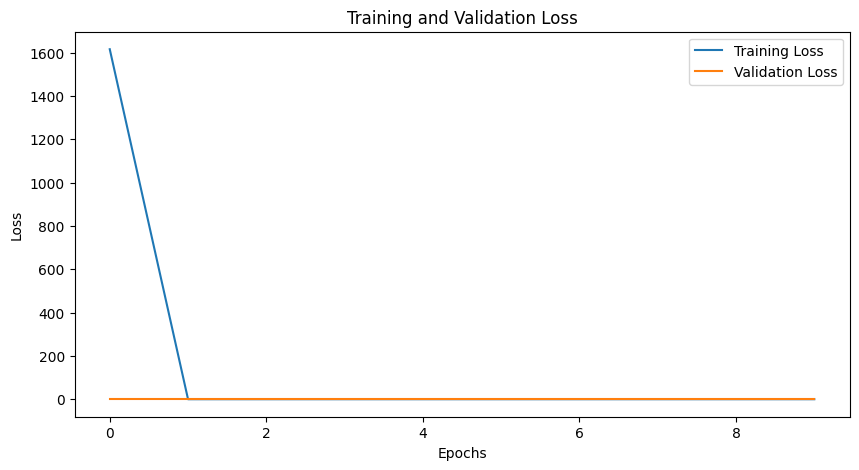

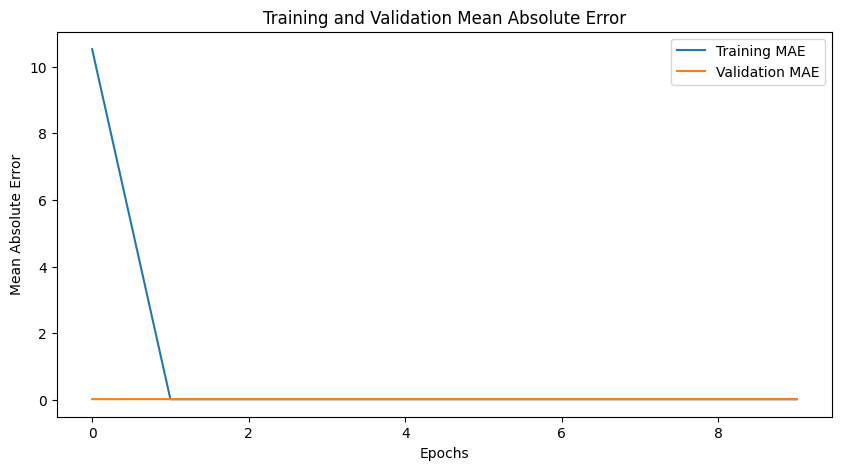

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


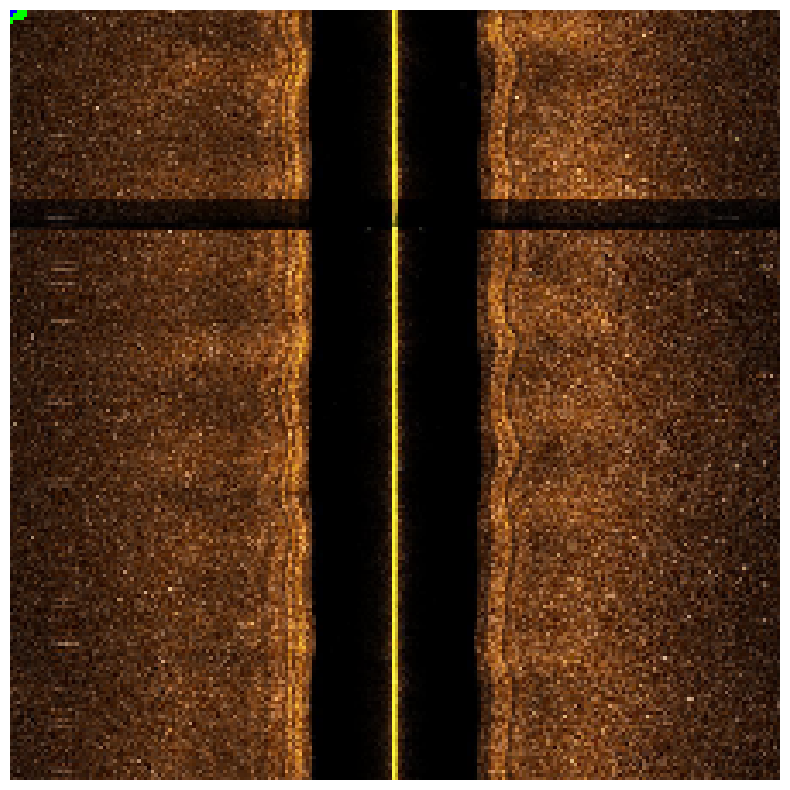

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


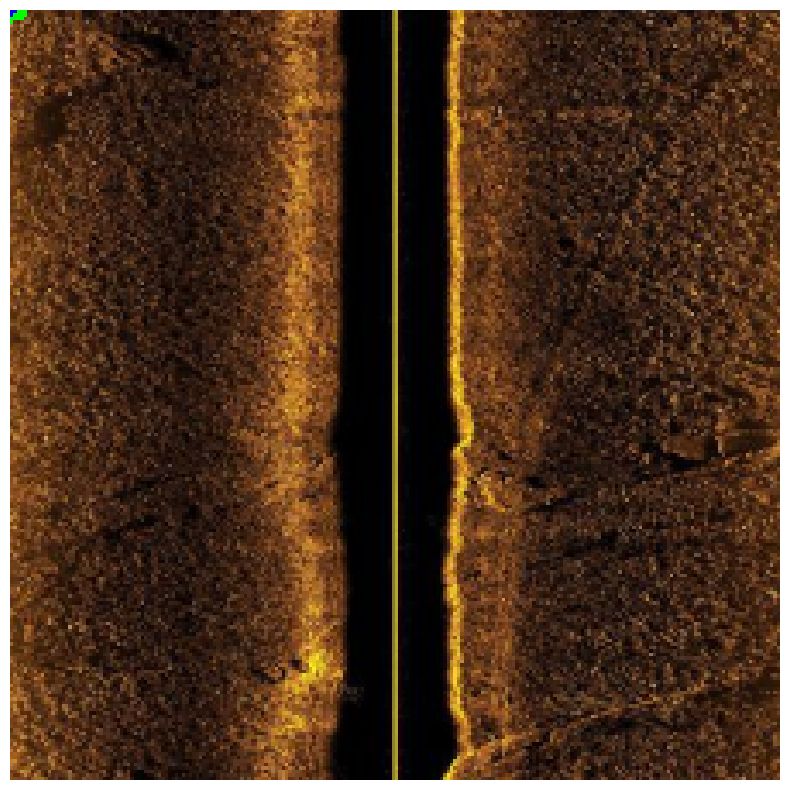

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


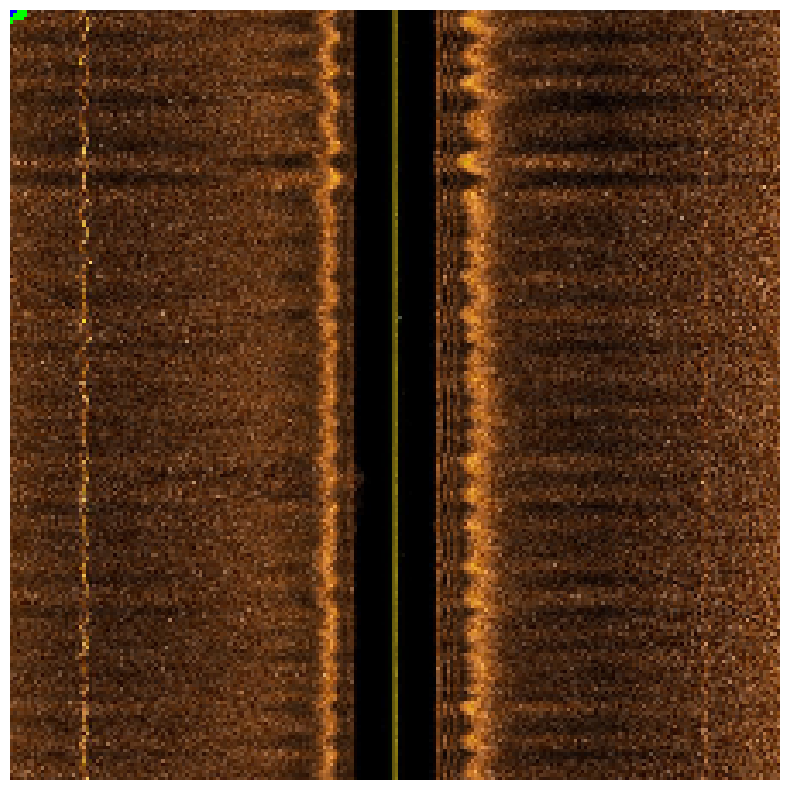

In [25]:
# Visualize predictions for sample test images
import matplotlib.pyplot as plt
import cv2

def visualize_sample(image, predictions, ground_truth=None):
    """
    Visualize a single image with predictions and optional ground truth.
    """
    img = image.copy()
    h, w, _ = img.shape

    # Draw predicted boxes
    for pred in predictions:
        class_id, x, y, width, height = pred
        x1 = int((x - width / 2) * w)
        y1 = int((y - height / 2) * h)
        x2 = int((x + width / 2) * w)
        y2 = int((y + height / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for predictions
        cv2.putText(img, f"Pred: {class_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw ground truth boxes if available
    if ground_truth is not None:
        for gt in ground_truth:
            class_id, x, y, width, height = gt
            x1 = int((x - width / 2) * w)
            y1 = int((y - height / 2) * h)
            x2 = int((x + width / 2) * w)
            y2 = int((y + height / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for ground truth
            cv2.putText(img, f"GT: {class_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example: Visualize predictions for a few test images
for i in range(3):  # Visualize 3 test samples
    test_image = X_test[i]
    test_ground_truth = y_test[i]

    # Expand dimensions and normalize the image
    test_image_batch = np.expand_dims(test_image, axis=0) / 255.0  # Normalize to match training input

    # Predict bounding boxes and class IDs
    predictions = model.predict(test_image_batch)[0]  # Remove batch dimension

    # Visualize predictions
    visualize_sample(test_image, predictions, ground_truth=test_ground_truth)
